In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Activation, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import SGD
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns



Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


This analysis is based on how the Convolutional Neural Networks(CNN) understand the images we feed them. The notion of Machine learning is to make machines think like humans. This experiment lets us know how the neural network sees the images and visualizes  it. This idea was inspired from https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html . The code snippets have been taken from this website and modified for CIFAR 10 data set. The CNN model has been implemented using Keras to visualize the filters and to visualize what input maximizes the accuracy of each class.

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
# Data set is loaded and preprocessed
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

batch_id = 3
sample_id = 7000
 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50000, num_workers=2)
#print(trainloader[0])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000,
                                         num_workers=2)

Classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# CNN is built using keras
model = Sequential()
 
model.add(Conv2D(32, (3, 3), activation='relu',
                  input_shape=(32, 32, 3)))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
 
model.compile(optimizer='sgd',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                72010     
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 72,906
Trainable params: 72,906
Non-trainable params: 0
_________________________________________________________________


In [5]:
for data1 in trainloader:
    x_train, y_train = data1

for data in testloader:    
    x_test, y_test = data

x_train = np.transpose(x_train,(0,3,2,1))

x_test = np.transpose(x_test,(0,3,2,1))
y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)



h = model.fit(x_train, y_train, 
                   epochs=20,
                   batch_size=64,
                   validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 30s 607us/step - loss: 1.8165 - accuracy: 0.3666 - val_loss: 1.6372 - val_accuracy: 0.4297
Epoch 2/20
50000/50000 [==============================] - 30s 601us/step - loss: 1.5356 - accuracy: 0.4714 - val_loss: 1.4737 - val_accuracy: 0.4778
Epoch 3/20
50000/50000 [==============================] - 30s 600us/step - loss: 1.3896 - accuracy: 0.5183 - val_loss: 1.3728 - val_accuracy: 0.5189
Epoch 4/20
50000/50000 [==============================] - 30s 598us/step - loss: 1.3028 - accuracy: 0.5500 - val_loss: 1.3320 - val_accuracy: 0.5296
Epoch 5/20
50000/50000 [==============================] - 30s 597us/step - loss: 1.2446 - accuracy: 0.5694 - val_loss: 1.2846 - val_accuracy: 0.5543
Epoch 6/20
50000/50000 [==============================] - 30s 598us/step - loss: 1.2019 - accuracy: 0.5851 - val_loss: 1.2373 - val_accuracy: 0.5699
Epoch 7/20
50000/50000 [==============================] 

In [6]:
score2 = model.evaluate(x_test, y_test, batch_size=100)
score2
#print((model2.inputs[0]))

10000/10000 [==============================] - 2s 199us/step


[1.0632730555534362, 0.6306999921798706]

In [7]:
ldict = dict([(l.name, l) for l in model.layers])
ldict.keys()

dict_keys(['conv2d_1', 'max_pooling2d_1', 'flatten_1', 'dense_1', 'activation_1'])

In [0]:
# Filters are visualized in layer 'conv2d_1' (layer name)
from keras import backend as K

def visfilter(filter_ind):

  layer_name = 'conv2d_1'
  w,h = 32, 32 # width and height of the image
  step = 0.05

  input_image = model.input
 
 # Loss function to maximize the activation of the considered layer
  out = ldict[layer_name].output
  loss = K.mean(out[:,:,:,filter_ind])

# Computing the gradient and normalizing it wrt the loss
  g = K.gradients(loss,input_image)[0]
  g /= (K.sqrt(K.mean(K.square(g))) + 1e-5)

# Function to give loss and gradient of the input image
  iterate = K.function(inputs=[input_image], outputs=[loss, g])

  ip_image_data = np.random.random((1, w, h, 3))

# Gradient ascent for 20 steps
  for i in range(20):
    lvalue, gvalue = iterate([ip_image_data])
    ip_image_data += gvalue*step


# Converting a tensor to an image by deprocessing it 
  def deprocess_image(x): 

    x -= x.mean()
    x /= (x.std() + 1e-5)
    x*=0.1

    x+=0.5
    x = np.clip(x, 0, 1)

    return x

  image = ip_image_data[0]
  image = deprocess_image(image)
  
  return image


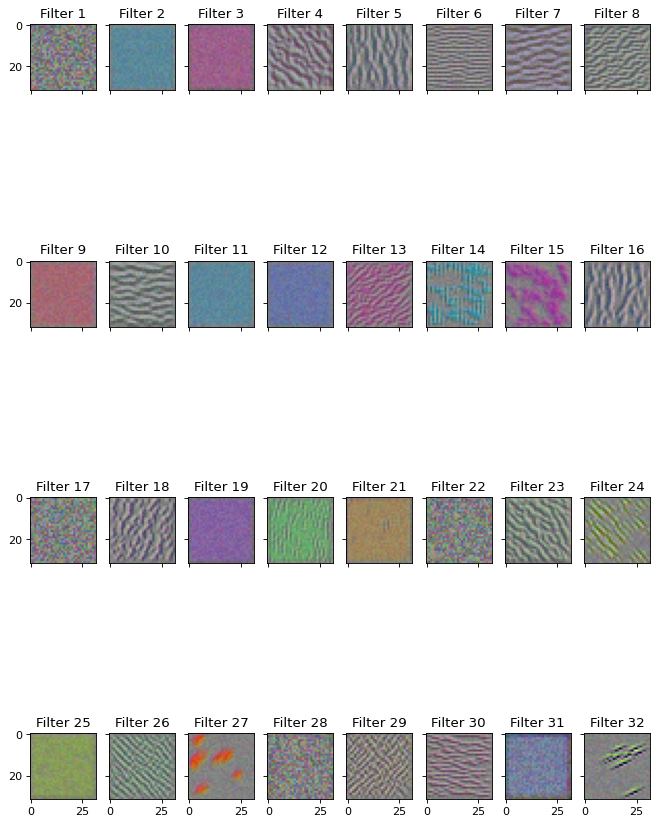

In [9]:
# Visualization of filters
filters = np.arange(32)
images = [visfilter(x) for x in filters]

figure, axes = plt.subplots(4, 8, sharex = True, sharey = True, figsize = (10,15), dpi = 80)

k=0
for i in range(4):
  for j in range(8):
    a = axes[i,j]
    a.imshow(images[k])
    a.set_title("Filter {}".format(k + 1))
    k = k+1


In [0]:
# Same approach as above to visualize the filters except here the output is not the filter but the label
def ideal(label):
  
  w,h = 32, 32 # width, height of the image
  step = 0.05

  input_image = model.input

  loss = K.mean(model.output[:,label])

  g = K.gradients(loss,input_image)[0]
  g /= (K.sqrt(K.mean(K.square(g))) + 1e-5)

  iterate = K.function(inputs=[input_image], outputs=[loss, g])

  ip_image_data = np.random.random((1, w, h, 3))
  loss_history = list()
  for i in range(20):
    lvalue, gvalue = iterate([ip_image_data])
    ip_image_data += gvalue*step
    loss_history.append(lvalue)

  def deprocess_image(x): 

    x -= x.mean()
    x /= (x.std() + 1e-5)
    x*=0.15

    x+=0.5
    x = np.clip(x, 0, 1)
  
    return x

  image = ip_image_data[0]
  image = deprocess_image(image)

  return image

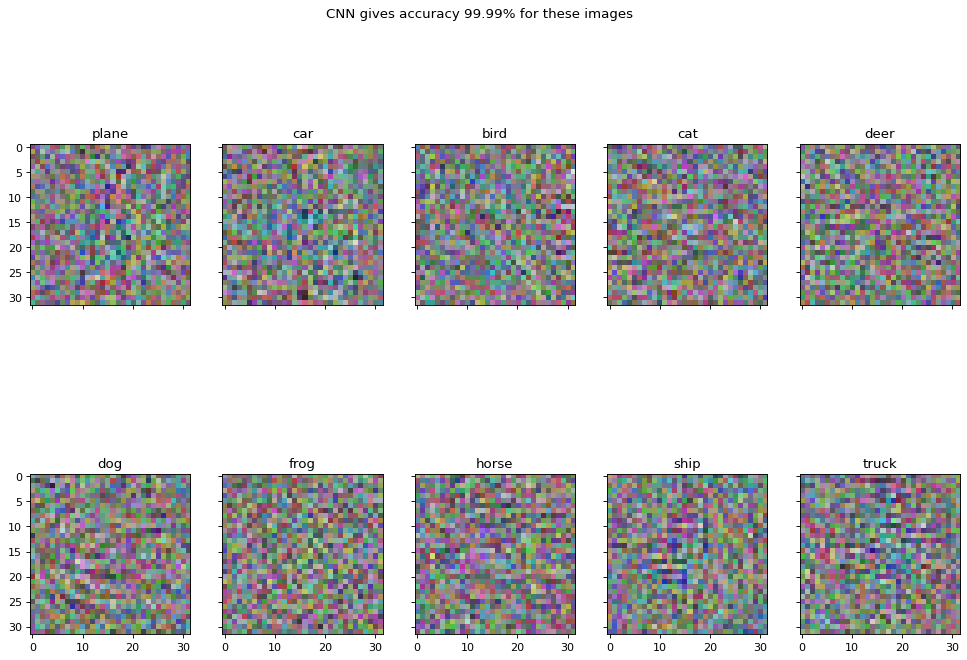

In [11]:
# Visulaization of images of ideal classes
lab = np.arange(10)
img = [ideal(x) for x in lab]

fig1, ax1 = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(15, 10), dpi=80)
fig1.suptitle("CNN gives accuracy 99.99% for these images")

m = 0
for i in range(2):
    for j in range(5):
        ax2 = ax1[i, j]
        ax2.imshow(img[m])
        ax2.set_title("{}".format(Classes[m]))
        m += 1
